In [1]:
pwd

'/Users/shreyakvashisht/PycharmProjects/Yay-Yay'

In [1]:
!pip install holidays==0.17.2


In [1]:
import  pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt
import seaborn as sns 
from sklearn.cluster import KMeans
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
#from holidays.countries import Entity
from fbprophet import Prophet
from fbprophet.plot import plot_plotly
import plotly.offline as py
py.init_notebook_mode()
%matplotlib notebook

In [2]:
import pandas
print (pandas.__version__)
#!pip install --upgrade numpy==1.23.4

1.5.2


In [3]:
!ls

README.rtf            main.py               users.csv
Yay-Yay.ipynb         stores.csv            venv
intital_users_gmv.csv transactions.csv


In [4]:
#pip install -U threadpoolctl
import warnings
warnings.filterwarnings("ignore")

In [3]:
# making all the neccessary imports 
transactions = pd.read_csv('transactions.csv')
stores = pd.read_csv('stores.csv')
users = pd.read_csv('users.csv')

In [4]:
transactions.sample(2)

id  \
1211218  92957dee-7ed7-6362-5a67-b47a847254da   
620230   5c2b8f25-071b-17fe-1757-f56742db6838   

                                      user_id  \
1211218  6a477023-5f1c-f4b2-1f48-01e657bc5738   
620230   58b3bfb8-c01f-f5e3-ad6b-73336e61d8b1   

                                     store_id            event_occurrence  \
1211218  4f6e0f4a-33df-be14-2b0f-6a9ca19b4d2b  2021-09-14 11:42:01.255695   
620230   0fca1799-bcdf-f9a1-5b6f-fb8f8a662f5c  2021-01-24 15:47:24.461585   

         amount  
1211218     488  
620230      249

In [5]:
stores.head(2)

id        nam       laa category  \
0  139a9a4b-1cb4-cb91-f718-d0bdd7db31c9  Aichi Ken  Agui Cho   ショッピング   
1  437e0dae-dbf7-b1a8-4a03-010b9597bbd2  Aichi Ken  Agui Cho    マッサージ   

         lat         lon  
0  34.951439  136.935126  
1  34.947078  136.884972

In [6]:
users.head(2)

id gender   age
0  3cf2d95c-851a-3e66-bd62-36050c1aa8dd      M  30.0
1  a85536f3-1bf8-fbeb-d06e-62e6dc5a2a83      M  55.0

### 1. Perform an exploratory data analysis to highlight patterns in the data using whatever visualizations you prefer. 

In [12]:
# two helper functions 
# ecdf is used to get empirical Cumulative Distribution Function for a particular variable 
# we use it to plor our entire daata and take a look at its distribution 
# another helper function used here is for box plots 
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y
def get_box_plot_data(labels, bp):
    rows_list = []

    for i in range(len(labels)):
        dict1 = {}
        dict1['label'] = labels[i]
        dict1['lower_whisker'] = bp['whiskers'][i*2].get_ydata()[1]
        dict1['lower_quartile'] = bp['boxes'][i].get_ydata()[1]
        dict1['median'] = bp['medians'][i].get_ydata()[1]
        dict1['upper_quartile'] = bp['boxes'][i].get_ydata()[2]
        dict1['upper_whisker'] = bp['whiskers'][(i*2)+1].get_ydata()[1]
        rows_list.append(dict1)

    return pd.DataFrame(rows_list)

<IPython.core.display.Javascript object>


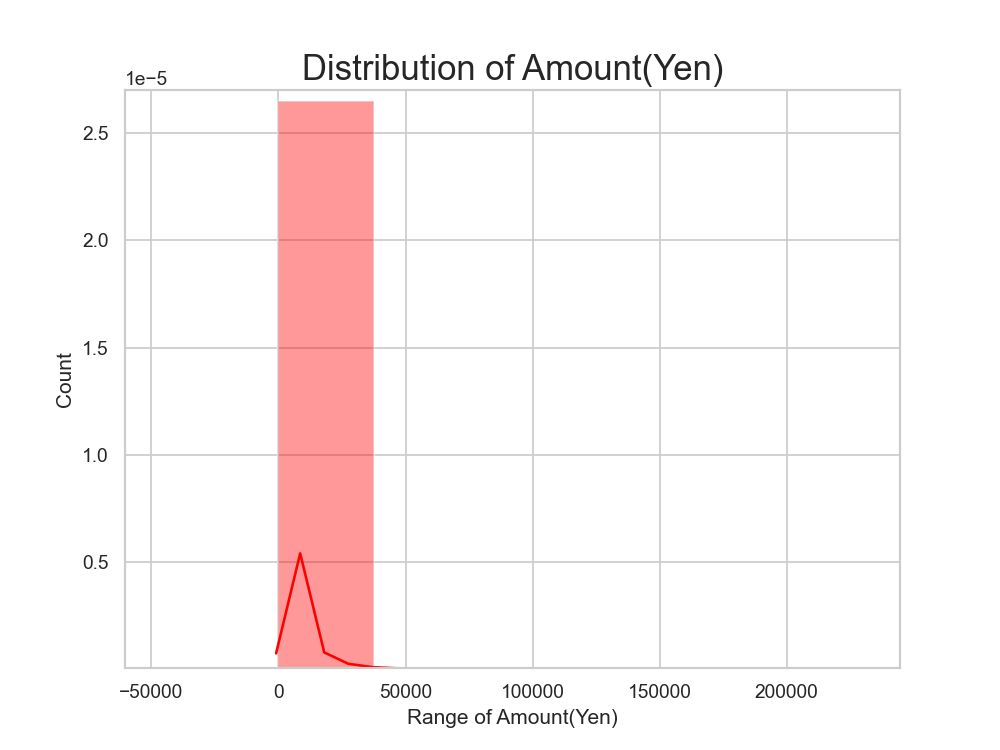

In [15]:
plt.rcParams["axes.formatter.limits"] = (-5, 12)
plt.rcParams["figure.figsize"] = (8,6)
plt.figure()
sns.set(style = 'whitegrid')
sns.distplot(transactions['amount'], color = 'red')
plt.title('Distribution of Amount(Yen)', fontsize = 20)
plt.xlabel('Range of Amount(Yen)')
plt.ylabel('Count')
plt.show()

<IPython.core.display.Javascript object>


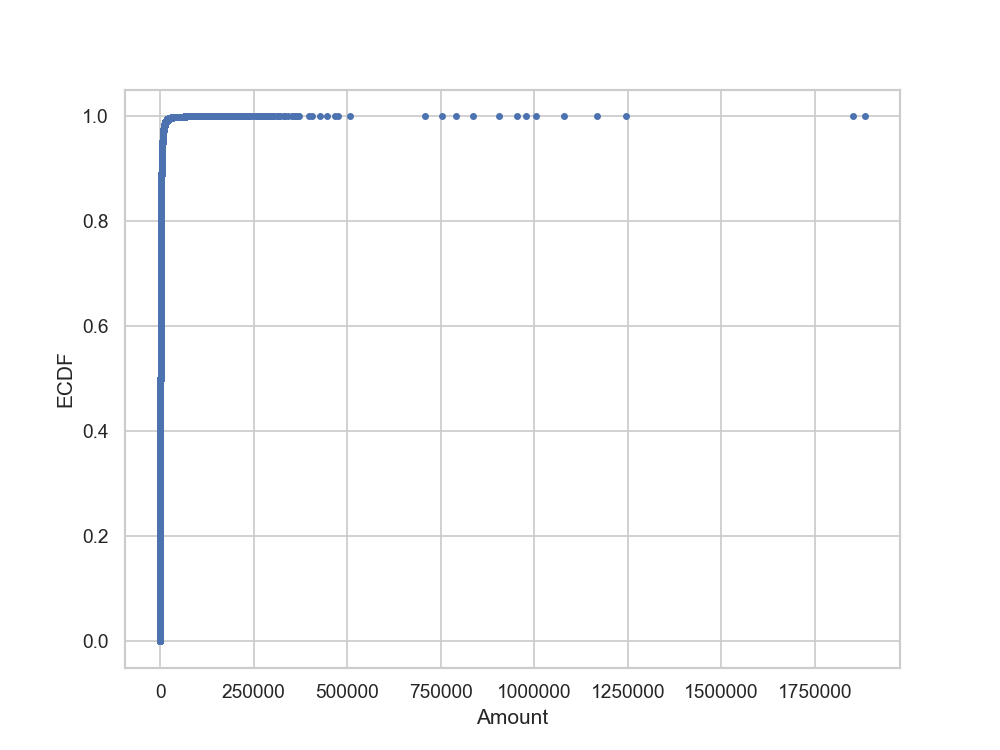

In [16]:
x_vers, y_vers = ecdf(transactions['amount'])
plt.rcParams["figure.figsize"] = (8,6)
# Generate plot
plt.figure()
_ = plt.plot(x_vers, y_vers, marker='.', linestyle='none')
# Label the axes
_ = plt.xlabel('Amount')
_ = plt.ylabel('ECDF')
plt.ticklabel_format(style='plain')
# Display the plot
plt.show()

In [17]:
labels = ['amount']
plt.ioff()#print(get_box_plot_data(labels, bp))
bp = plt.boxplot([transactions['amount']], labels=labels)
get_box_plot_data(labels, bp)

label  lower_whisker  lower_quartile  median  upper_quartile  \
0  amount            2.0           332.0   732.0          1675.0   

   upper_whisker  
0         3689.0

In [18]:
q1, q3 = np.percentile(transactions['amount'], [25, 75])
iqr = q3 - q1
lower_bound = q1 - 1.5*iqr
upper_bound = q3 + 1.5*iqr
print('upper_bound of amount is {}'.format(lower_bound))
print('lower_bound of amount is {}'.format(upper_bound))

upper_bound of amount is -1682.5
lower_bound of amount is 3689.5


insight: 
1. after analyszing on the above plot and looking at the distribution empherically it is clear that 90% of all the transcations fall below  the amount 3750 yen(~close to upper bound)
2. based on the IQR(interquartile range) 10% of ALL transactions amount seems anamolous(above the upper bound) 

In [8]:
# merging transactions with stores via a left join 
transactions_stores = pd.merge(transactions, stores, how='left',left_on='store_id', right_on='id')

In [9]:
# merging transactions and stores  with users via a left join 
transactions_stores_users  = pd.merge(transactions_stores, users, how='left',left_on='user_id', right_on='id')

In [18]:
# Fit KMeans and calculate SSE for each k
sse = {}
for k in range(2, 15):
  
    # Initialize KMeans with k clusters
    kmeans = KMeans(n_clusters=k, random_state=1)
    
    # Fit KMeans on the normalized dataset
    kmeans.fit(transactions_stores_users['amount'].values.reshape(-1,1))
    
    # Assign sum of squared distances to k element of dictionary
    sse[k] = kmeans.inertia_

reasoning:<linebr>
To further mine our data, we want to take help of a clustering algo. which can efficenlty split our amount into multple clusters.(we also wanted to add age but due to missing data we only use amount as the param. to custer on).   <linebr>to decide the number of clusters we use the help of the elbow plot, by plotting sum of sum of squared distance and picking the point where sse is decreasing and starts to resemble a straight line(elbow point)   

<IPython.core.display.Javascript object>


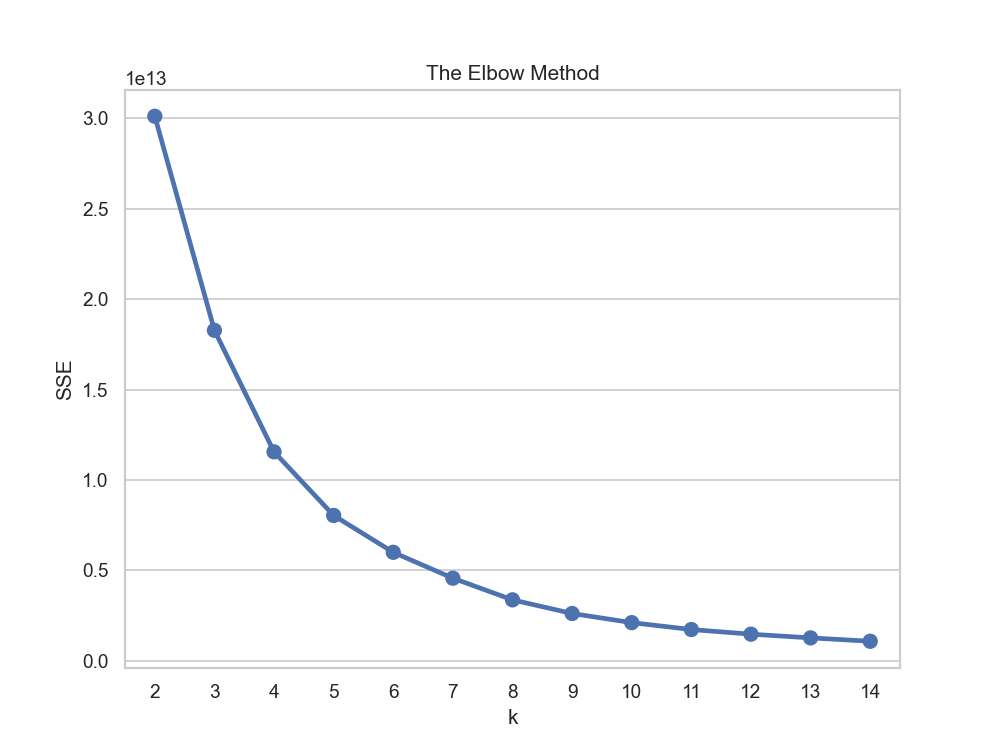

In [21]:
plt.figure()
plt.title('The Elbow Method')

# Add X-axis label "k"
plt.xlabel('k')

# Add Y-axis label "SSE"
plt.ylabel('SSE')

# Plot SSE values for each key in the dictionary
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [21]:
# looking at the above plot we see the elbow point as 5,
# hence 5 is the number of clusters chosen 
kmeans = KMeans(n_clusters=5, random_state=1) 
# Fit k-means clustering on the normalized data set
kmeans.fit(transactions_stores_users['amount'].values.reshape(-1,1))
# Extract cluster labels
cluster_labels = kmeans.labels_
transactions_stores_users['clustering_lables']  = cluster_labels

In [15]:
# perfroming a group by aggregation to get an idea of what each clustering label represent 
#transactions_stores_users['clustering_lables'].value_counts()
transactions_stores_users.groupby('clustering_lables').agg({'amount':np.median}).reset_index().sort_values('amount')

clustering_lables    amount
1                  1     662.0
0                  0    7362.5
3                  3   31224.5
4                  4  147447.5
2                  2  976786.0

In [22]:
# looking at labels from a prespective of counts 
transactions_stores_users['clustering_lables'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

1    93.3%
0     6.3%
3     0.4%
4     0.0%
2     0.0%
Name: clustering_lables, dtype: object

<IPython.core.display.Javascript object>


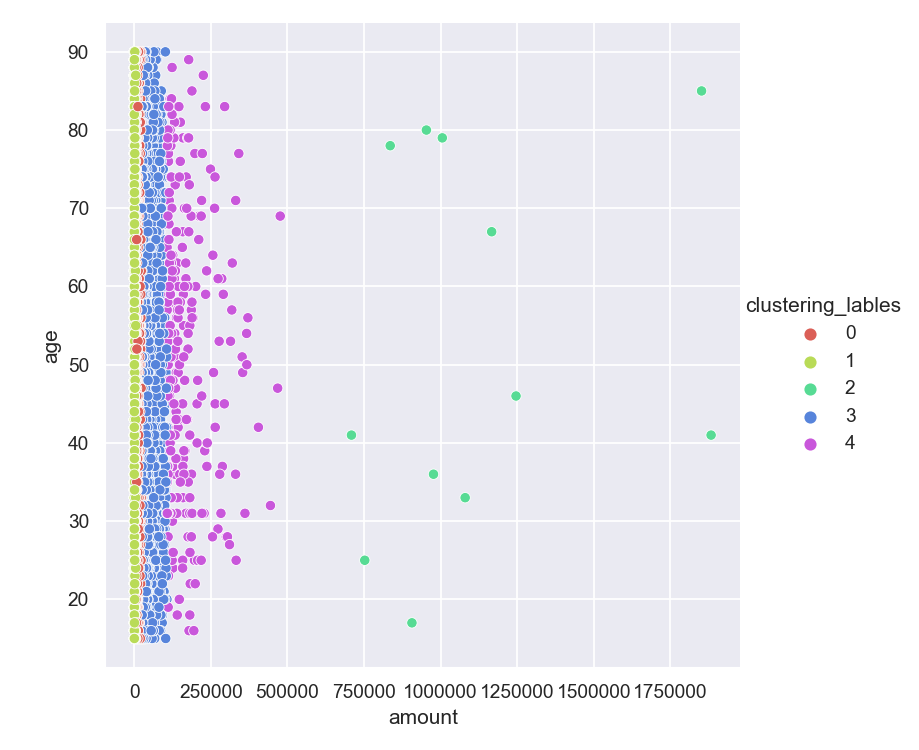

In [23]:
# the purpose of the plot is to visually display and identify
# the relation between amount age and labels 
plt.ion()
palette = sns.color_palette("hls", 5)
sns.set_theme(rc={'axes.formatter.limits': (-8, 9)})
sns.relplot(
    x="amount", y="age", hue="clustering_lables", data=transactions_stores_users, height=6,palette=palette
    
)

insight:
<linebr>
it is pretty evident by descriptive stats(and by analyzing the plot) that 0 and 3 cluster lables are in majortiy and cluster lables 2,1,4 contribute to only a very small portion of the population <br>
after analyzing the plot we also dont see a specfic age range densely contributing to a specific cluster label

<IPython.core.display.Javascript object>


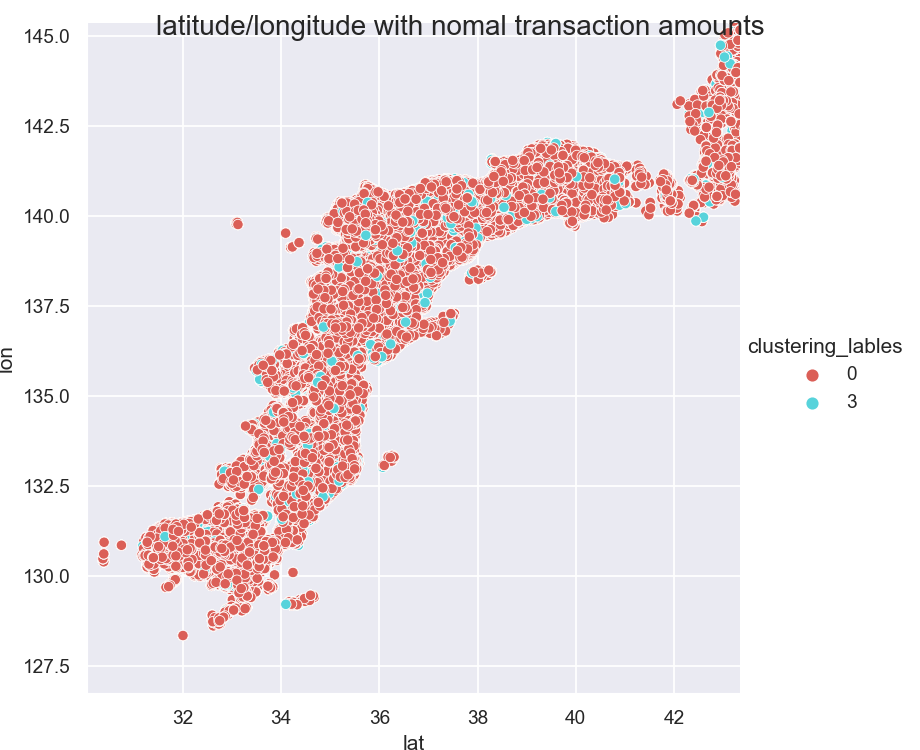

Text(0.5, 0.98, 'latitude/longitude with nomal transaction amounts')

In [53]:
## plotting lat/longitudes only for majority transactions(normal) 
plot =sns.relplot(
    x="lat", y="lon", hue="clustering_lables", 
    data=transactions_stores_users[transactions_stores_users['clustering_lables'].isin([0,3])], height=6,
    palette= sns.color_palette("hls", 2)
    
)
plot.fig.suptitle("latitude/longitude with nomal transaction amounts",
                  fontsize=16, fontdict={"weight": "bold"})

<IPython.core.display.Javascript object>


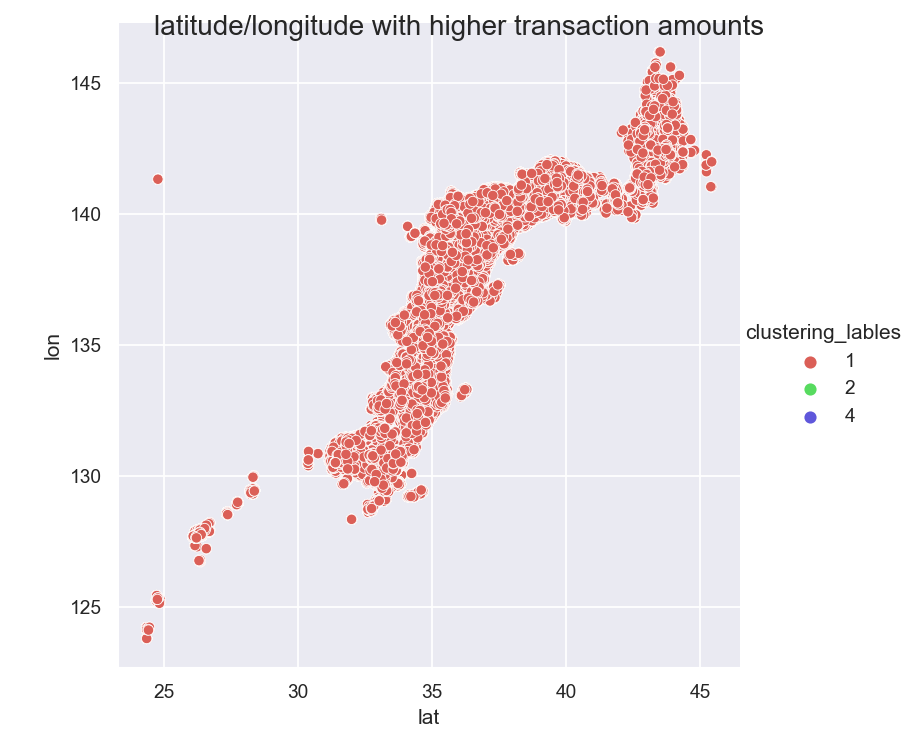

Text(0.5, 0.98, 'latitude/longitude with higher transaction amounts')

In [24]:
## plotting lat/longitudes only for higher transactions(normal) 
plot =sns.relplot(
    x="lat", y="lon", hue="clustering_lables", 
    data=transactions_stores_users[transactions_stores_users['clustering_lables'].isin([2,1,4])], height=6,
    palette= sns.color_palette("hls", 3)
    
)
plot.fig.suptitle("latitude/longitude with higher transaction amounts",
                  fontsize=16, fontdict={"weight": "bold"})

<IPython.core.display.Javascript object>


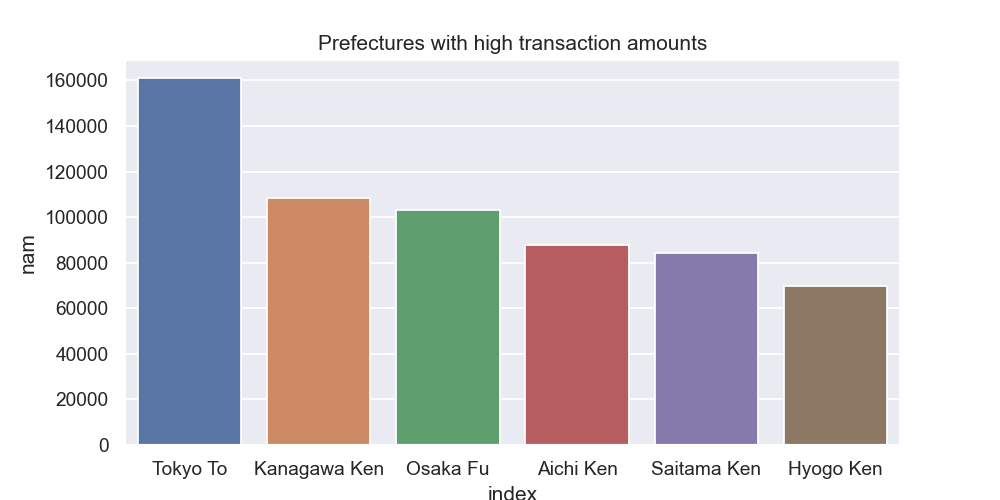

Text(0.5, 1.0, 'Prefectures with high transaction amounts')

In [25]:
high_amount_clusters = transactions_stores_users[transactions_stores_users['clustering_lables'].isin([1,4,2])]['nam'].\
value_counts().reset_index().head(6)
sns.set(rc={'figure.figsize':(8,4)})
plt.figure()
sns.barplot(data=high_amount_clusters.reset_index(), x='index', y='nam').set_title("Prefectures with high transaction amounts")

<IPython.core.display.Javascript object>


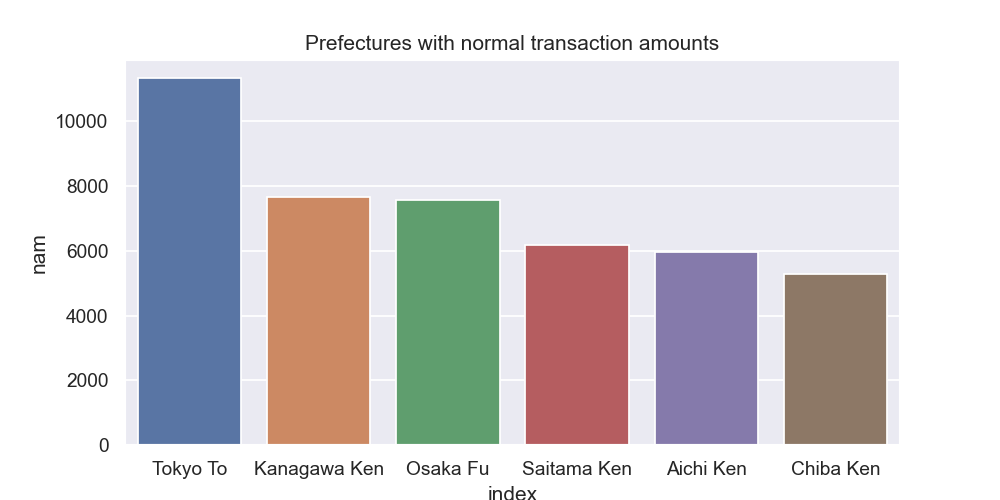

Text(0.5, 1.0, 'Prefectures with normal transaction amounts')

In [26]:
normal_amount_clusters = transactions_stores_users[transactions_stores_users['clustering_lables'].isin([0,3])]['nam'].\
value_counts().reset_index().head(6)
sns.set(rc={'figure.figsize':(8,4)})
plt.figure()
sns.barplot(data=normal_amount_clusters.reset_index(), x='index', y='nam').set_title("Prefectures with normal transaction amounts")

Insight: we used a simple clustering alogrithm to categorize amounts into diffrent cluster levels to understand the densities based on the geographical location,after analising both the types of plots above we can see that transaction amounts are not concentrated based on their values but on the overall frequencies of the transactions.<br> we intitally thought that some anamalous higher transactions might have been concnetrated to particular geographical region but that does not seem to be the case      

In [10]:
transactions_time_series = transactions_stores_users[['event_occurrence','amount']]
transactions_time_series['event_occurrence'] = pd.to_datetime(transactions_time_series['event_occurrence'])
transactions_time_series = transactions_time_series.set_index('event_occurrence')

/var/folders/k4/j63_sy9x4858dvxwghlsdy140000gn/T/ipykernel_52265/2299745434.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<IPython.core.display.Javascript object>


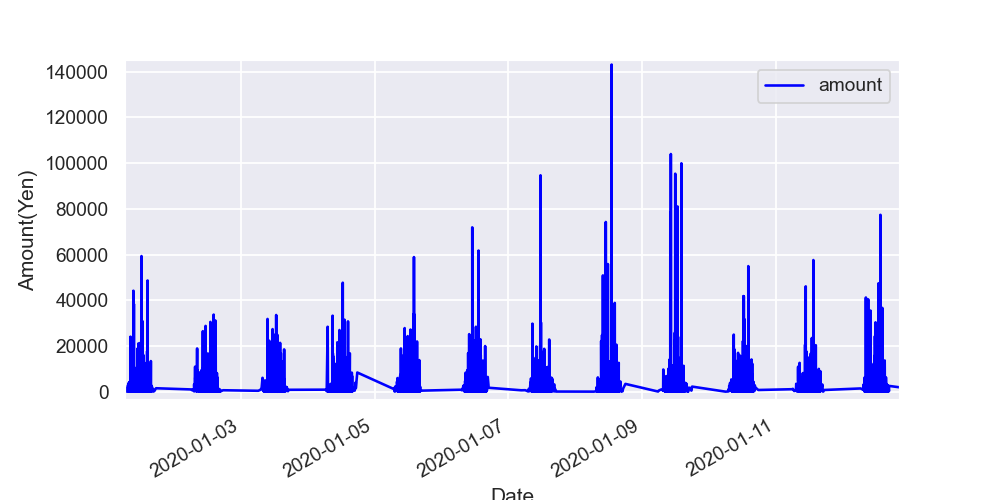

In [29]:
ax = transactions_time_series.plot(color='blue')
# Specify the x-axis label in your plot
ax.set_xlabel('Date')
# Specify the y-axis label in your plot
ax.set_ylabel('Amount(Yen)')
plt.show()

insight: looking at the time series we can see there is very clear daily seasonal component, the transactions starts everyday around 8 AM and around 4 PM the transasction slows down until the next day, it implies that our customers are heavily utilizing our service during this time  

In [30]:
# extracting the trend of the time series 
decomposition = sm.tsa.seasonal_decompose(transactions_time_series.head(100000),model='additive', period=1583)
# period of 1583 is chosen based on the fact that this period reperesents when a 
# particular time series starts repeating itself. In a day we can see around ~1600 transactions hence the number  

<IPython.core.display.Javascript object>


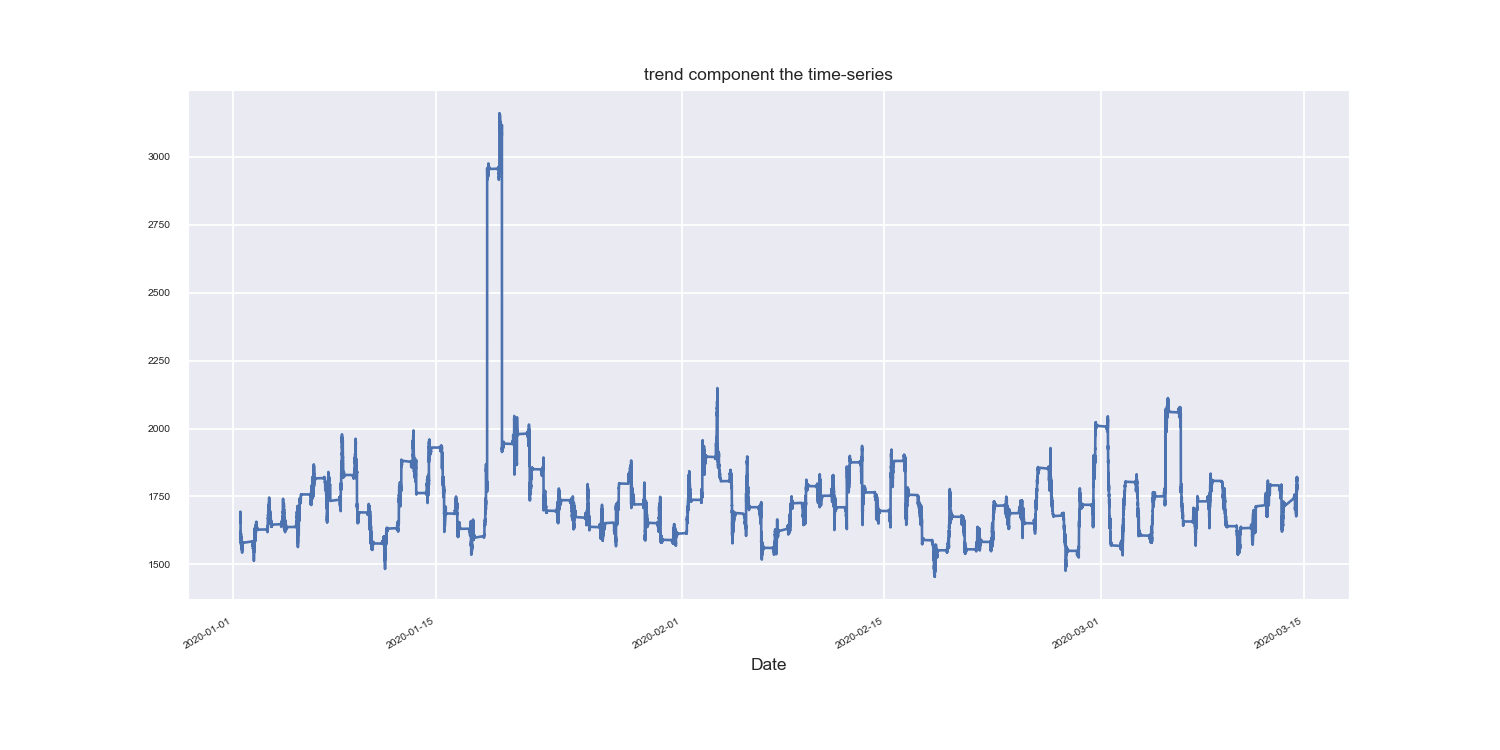

In [32]:
# Extract the trend component and potting it 
trend = decomposition.trend
plt.figure()
# Plot the values of the trend
ax = trend.plot(figsize=(12, 6), fontsize=6)
# Specify axis labels
ax.set_xlabel('Date', fontsize=10)
ax.set_title('trend component the time-series', fontsize=10)
plt.show()

Insight: another insight attributing to the cyclic trend is that weekdays are on average covering more trasnactional amount than the weekends. it is evident after analyzing the plot that we see a comparitive decline towards the end of the week, this gives us overview trend on the  csutomer usage pattern    

### 2. Forecast GMV for each user for the month of January 2022

In [11]:
transactions_stores_users['event_occurrence'] = pd.to_datetime(transactions_stores_users['event_occurrence'])
transactions_stores_users['event_occurrence_month'] = transactions_stores_users['event_occurrence'].dt.month
transactions_stores_users['event_occurrence_year'] =transactions_stores_users['event_occurrence'].dt.year 
transactions_stores_users['year_month'] = transactions_stores_users['event_occurrence_year'].astype(str) + "-" + transactions_stores_users['event_occurrence_month'].astype(str)

In [12]:
#transactions_stores_users.groupby(['year_month','user_id']).agg({'amount'}:np.median).reset_index()
gmv_users = transactions_stores_users.groupby(['year_month','user_id']).agg({'amount':sum}).reset_index()#.sort_values('amount')

here the logic for the group by is that we need to Predict GMV for each user, this could be possible if we had daily data but since the data between the days is missing for many users we are rolling the sum of transctions on a monthly level and will predict for the month of January(for each user)

Also to add, out of 9542 users, 8850 are not ending 2021-12-01 this means that the we will have to forecast way ahead in the future and this might result in some loss of accuracy. 

In [13]:
gmv_users['year_month'] = pd.to_datetime(gmv_users['year_month'])
#gmv_users

In [334]:
### running a counter to check stationarity using adf 
# total_counter = 0
# stationarity_counter = 0
# for  i in gmv_users['user_id']:
#     s = gmv_users[gmv_users['user_id']==i].sort_values('year_month')
#     #print(s['amount'])
#     if len(s)>=4:
#         #print('adf_______',i)
#         result = adfuller(s['amount'].values)
#         if result[1] > 0.05:
#              stationarity_counter = stationarity_counter+1
#         total_counter = total_counter+1
print("total_stationarity check dones ={}".format(total_counter))
print("non stationaritytime series found ={}".format(stationarity_counter))

total_stationarity check dones =28697
non stationaritytime series found =11223


checking stationarity using Augmented Dickey-Fuller test

to predict on the user level, we would have to make these time series stationarity, in the intrest of time<br>
the best way possible would be to use auto arima that will take care of selecting the best model for us and will also give us the best values for P,Q,R(lag order,degree of differencing,moving average)

In [12]:
all_unique_users = list(gmv_users['user_id'].unique())
len(all_unique_users)

9542

In [45]:
## running this cell might take over an hour so holding it to only 5 users 
from datetime import datetime
user_id_lis = []
GMV_forecasted_val_lis = []
for i in all_unique_users[:5]:
    #print(i)
    s = gmv_users[gmv_users['user_id']==i].sort_values('year_month')
    # calculating the last month for each user
    # if its not '2021-12-01' then we calculate the 
    # difference betweeen the existing date and the date we are going to forecast  
    if list(s['year_month'].astype(str).tail(1))[0]!='2021-12-01':
        lower_date = list(s['year_month'].astype(str).tail(1))[0]
        print(lower_date)
        date_format = "%Y-%m-%d"
        a = datetime.strptime(lower_date, date_format)
        b = datetime.strptime('2021-12-01', date_format)
        delta = b - a
        month_dff = round(delta.days/30)+1
        print(month_dff)
    else:
        month_dff = 1
    s = s[['year_month','amount']]
    s = s.set_index('year_month')

    try:
        print(i)
        # using auto arima here 
        auto_arima_model = pm.auto_arima(s, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=6, # maximum p and q
                      m=24,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   #  Seasonality due to our eda above 
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
        forcasted_values = auto_arima_model.predict(n_periods=month_dff, return_conf_int=True)
        print(forcasted_values[0],'selectedvlaue is ____',list(forcasted_values[0])[-1])
        if list(forcasted_values[0])[-1] !=0:
            GMV_forecasted_val_lis.append(list(forcasted_values[0])[-1]) # appending the forecasted vlaues 
            user_id_lis.append(i)
        else:
            raise Exception('value too small trigger forecast') # if the dataframe is too small for auto arima then
                                                                # we trigger an exception to use reglar arima
    
    except Exception as e:
        try:
            print('Regular-arima',i)
            # using regirlar arima of the order (2,1,2), this order was used looking at acf/pacf plots
            arima_model = sm.tsa.arima.ARIMA(s,order = (2,1,2))
            forcasted_values  =arima_model.fit()
            forcasted_values = forcasted_values.get_forecast(steps = month_dff)
            print(forcasted_values.predicted_mean,'selectedvlaue is ____',list(forcasted_values.predicted_mean)[-1])   
            #model = sm.tsa.arima.ARIMA(tet_adf[:22],order = (2,0,1))
            user_id_lis.append(i)
            GMV_forecasted_val_lis.append(list(forcasted_values.predicted_mean)[-1])
        except Exception as e:
            arima_model = sm.tsa.arima.ARIMA(s,order = (1,2,1))
            forcasted_values  =arima_model.fit()
            forcasted_values = forcasted_values.get_forecast(steps = month_dff)
            print(forcasted_values.predicted_mean,'selectedvlaue is ____',list(forcasted_values.predicted_mean)[-1])   
            #model = sm.tsa.arima.ARIMA(tet_adf[:22],order = (2,0,1))
            user_id_lis.append(i)
            GMV_forecasted_val_lis.append(list(forcasted_values.predicted_mean)[-1])
        

explanation of the above cell block:<linebr>
we are looping through each unique user id, for which we need to generate a forecast and we calcuate how many months ahead we need to look at in order to reach January 2022, we are using two models here our preference is autoarima 
but we are using regular arima with preset order of (2,1,2), we came up with this order using a very rudimentary process this can be better through analysing AZF/PACF but for teh sake of time we have gone ahead      

In [28]:
#intital_users_gmv = pd.DataFrame({'ids':user_id_lis,'Forecasted_gmv_values':GMV_forecasted_val_lis})
intital_users_gmv =pd.read_csv('intital_users_gmv.csv')

In [16]:
#intital_users_gmv.to_csv('intital_users_gmv.csv')

## 3. Forecast GMV for YayYay as a whole for each date in the month of January 2022

In [14]:
transactions_stores_users['event_occurrence_date'] = transactions_stores_users['event_occurrence'].dt.date

In [15]:
#gmv_users = transactions_stores_users.groupby(['year_month','user_id']).agg({'amount':sum}).reset_index()#.sort_values('amount')
gmv_users.head(2)

year_month                               user_id  amount
0 2020-01-01  00183cfe-ceb0-9220-7984-f33f61c61ae4   25306
1 2020-01-01  001b10c4-0ec1-68c9-a059-0a44159119bd    6222

In [16]:
gmv_total = transactions_stores_users.groupby(['event_occurrence_date']).agg({'amount':sum}).reset_index()

for the forecast as a whole, we are aggregating by a single day instaed of a month (like we did in part2)cause we have the data available for each, hence we can produce a forecast 30 days ahead 

In [17]:
gmv_total['event_occurrence_date'] = pd.to_datetime(gmv_total['event_occurrence_date'])
#gmv_total

In [17]:
# using ADF to check stationary
result = adfuller(gmv_total['amount'].values)

In [18]:
pd.options.display.float_format = '{:.2f}'.format
result[1]

0.9987606470579073

testing uing ADF clearly our time series is Not stationary

In [18]:
# breaking our data into train and test to test out the validity of our forecasts 
train = gmv_total[gmv_total['event_occurrence_date']<='2021-11-30']
test = gmv_total[gmv_total['event_occurrence_date']>'2021-11-30']

In [77]:
model = pm.auto_arima(train.amount, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=14,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      #stepwise=True
                     )

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[14] intercept   : AIC=19854.183, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[14] intercept   : AIC=20201.525, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[14] intercept   : AIC=20033.174, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[14] intercept   : AIC=19852.063, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[14]             : AIC=20199.599, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[14] intercept   : AIC=19876.315, Time=0.04 sec
 ARIMA(0,1,1)(1,0,1)[14] intercept   : AIC=19854.007, Time=0.33 sec
 ARIMA(0,1,1)(0,0,2)[14] intercept   : AIC=19846.814, Time=0.70 sec
 ARIMA(0,1,1)(1,0,2)[14] intercept   : AIC=19846.238, Time=1.54 sec
 ARIMA(0,1,1)(2,0,2)[14] intercept   : AIC=inf, Time=2.15 sec
 ARIMA(0,1,1)(2,0,1)[14] intercept   : AIC=inf, Time=1.79 sec
 ARIMA(0,1,0)(1,0,2)[14] intercept   : AIC=20150.774, Time=0.94 sec
 ARIMA(1,1,1)(1,0,2)[14] intercept   : AIC=inf, Time=2.77 sec
 ARIMA(0,1,2)(1,0,2)[14] intercept   : AIC=inf, Time=2.34 sec
 ARIMA(1,1,0)(1,0,2)[14] inte

We would like to set 365 as m vlaue as “frequency” is the number of observations per “cycle” 
and we are looking at yearly data recorded dail but to find out the correct arima params would take some addtional time so we are going with bi weekly(14)

In [78]:
future_forecast = model.predict(n_periods=len(test))
future_forecast = pd.DataFrame(future_forecast,
                               index=test.index,
                               columns=['prediction'])
#pd.concat([test, future_forecast], axis=1)

<IPython.core.display.Javascript object>


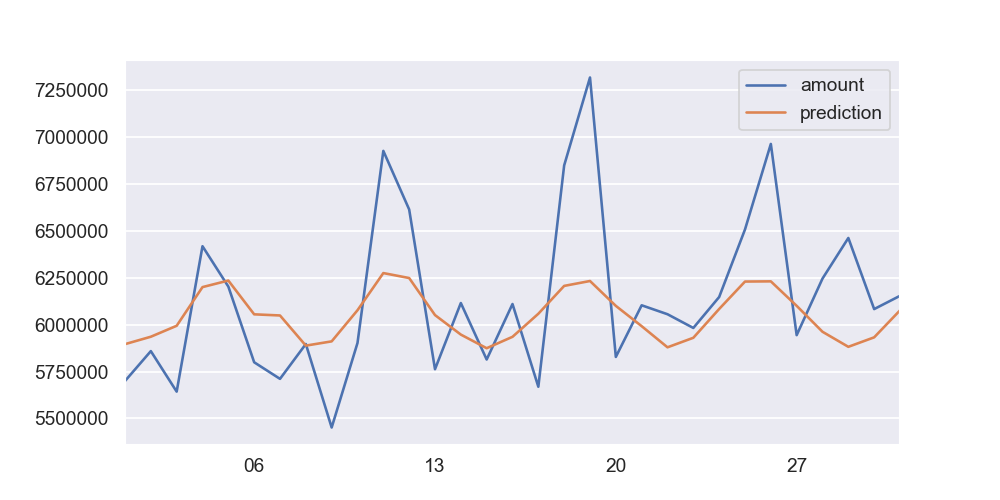

In [80]:
pred_frame = pd.concat([test, future_forecast], axis=1)

plt.rcParams["axes.formatter.limits"] = (-5, 12)
#pred_frame.plot(x="event_occurrence_date", y=["amount", "prediction"])
#plt.ticklabel_format(style='plain')
pred_frame.set_index('event_occurrence_date').plot();

## 3.2 Trying to see if FB Prophet gives us a better performance

In [20]:
#!pip install fbprophet
#!pip install "prophet==1.1.4"
#!pip install holidays==0.17.2
#!pip install fbprophet --upgrade
#!pip install pystan==2.19.1.1
from fbprophet import Prophet
import fbprophet
print(fbprophet.__version__)
#!pip uninstall prophet --y

0.7.1


In [82]:
train.head(1)

event_occurrence_date   amount
0            2020-01-01  2633813

In [83]:
df = train.rename(columns={'event_occurrence_date': 'ds',
                        'amount': 'y'})

In [84]:
my_model = Prophet(interval_width=0.95)
my_model.fit(df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -6.85838


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1805.85   0.000408177       66.5387      0.4974      0.4974      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     177       1811.51   0.000401454       200.812   1.098e-06       0.001      264  LS failed, Hessian reset 
     199       1812.21   8.02422e-05       46.0676     0.05965           1      295   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     224       1812.26   0.000133184       67.3086   1.935e-06       0.001      361  LS failed, Hessian reset 
     252       1812.28   2.45393e-07       51.0885      0.2363           1      403   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [85]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
future_dates = my_model.make_future_dataframe(periods=30,)
forecast = my_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

ds        yhat  yhat_lower  yhat_upper
0 2020-01-01 2254723.006 1612512.907 2871751.764
1 2020-01-02 2272264.181 1669423.411 2868931.579
2 2020-01-03 2220098.201 1631556.165 2837962.890
3 2020-01-04 2563397.090 1947799.847 3172573.330
4 2020-01-05 2578628.496 2018342.903 3183757.922

In [86]:
forecast['ds'] = pd.to_datetime(forecast['ds'])

<IPython.core.display.Javascript object>


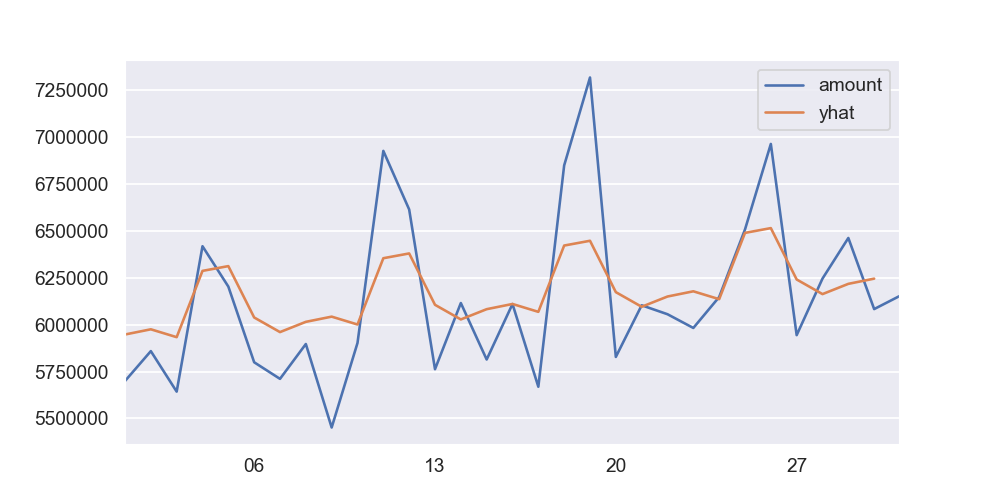

<Axes: xlabel='event_occurrence_date'>

In [87]:
plt.rcParams["axes.formatter.limits"] = (-5, 12)
pd.concat([test, forecast[(forecast['ds']>'2021-11-30')]], axis=1)[['event_occurrence_date','amount','yhat']].set_index('event_occurrence_date').plot()

looking at both plots, visually its difficult to see if using prophet made any difference, lets use mape to check

In [88]:
## mape funtion 
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [89]:
mean_absolute_percentage_error(pd.concat([test, forecast[(forecast['ds']>'2021-11-30')]], axis=1)[:-1]['amount'],
                              pd.concat([test, forecast[(forecast['ds']>'2021-11-30')]], axis=1)[:-1]['yhat'])

3.929232980331196

In [90]:
mean_absolute_percentage_error(pred_frame['amount'],
                              pred_frame['prediction'])

4.5302889922036575

choosing fb prophet due to lower value of mape.  

## 3.3 Fine tuning FB Prophet

In [91]:
from sklearn.model_selection import ParameterGrid
# creating a Param grid whcih will be  used to iter all possible combinations 
params_grid = {'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'holidays_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'n_changepoints' : [100,150,200]}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 150


In [92]:
import random

model_parameters = pd.DataFrame(columns = ['MAPE','Parameters'])
for p in grid:
    #test = pd.DataFrame()
    print(p)
    random.seed(0)
    train_model =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                         holidays_prior_scale = p['holidays_prior_scale'],
                         n_changepoints = p['n_changepoints'],
                         seasonality_mode = p['seasonality_mode'],
#                          weekly_seasonality=True,
#                          daily_seasonality = True,
#                          yearly_seasonality = True,
                         interval_width=0.95)
    #train_model.add_country_holidays(country_name='US')
    train_model.fit(df)
    train_forecast = train_model.make_future_dataframe(periods=30,)
    train_forecast = train_model.predict(train_forecast)
    #test=train_forecast[['ds','yhat']]
    Actual = pd.concat([test, train_forecast[(train_forecast['ds']>'2021-11-30')]], axis=1)[:-1]['amount']
    predcited = pd.concat([test, train_forecast[(train_forecast['ds']>'2021-11-30')]], axis=1)[:-1]['yhat']
    MAPE = mean_absolute_percentage_error(Actual,predcited)
    print('Mean Absolute Percentage Error(MAPE)------------------------------------',MAPE)
    model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1824.48    0.00073712       203.432      0.1134           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1826.43    0.00450773        101.06           1           1      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1827.79   0.000319723       96.0336           1           1      356   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1828.99   0.000801422       176.791      0.2117      0.2117      472   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     452       1830.26    0.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.5023411308816317
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1817.97      0.011556       235.294           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1820.67   0.000480274       145.529           1           1      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     256       1821.36    6.1159e-05       108.486   3.497e-07       0.001      350  LS failed, Hessian reset 
     299        1821.7   0.000195221        66.031      0.5811      0.5811      401   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399  

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.157104518282781
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1824.04    0.00140868       146.432      0.2746           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1826.04   0.000623766       199.108      0.7872      0.7872      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1826.6    0.00320503       101.209           1           1      370   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1827.39   0.000217778       75.0699      0.9207      0.9207      483   
    Iter      log prob       

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.4917185584498642
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1817.35    0.00309718       222.842      0.3996      0.9645      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1819.5   0.000268126       120.984           1           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1820.64   0.000147792       71.2459       0.287       0.287      354   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1821.16    0.00251049       128.849      0.4784      0.4784      462   
    Iter      log prob        ||dx

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.1514144233817
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1823.61    0.00247708       169.485      0.1599           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1825.42   0.000439728        147.32      0.5297      0.5297      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1826.38   0.000618028       148.856      0.5586      0.5586      355   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1827.38   0.000943138       110.864           1           1      471   
    Iter      log prob        |

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.4922867615552176
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1817.08    0.00136692       93.0593           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1819.25   0.000569078       135.884           1           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1820.21   0.000710208        82.445           1           1      351   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1820.94    0.00143589       195.857           1           1      462   
    Iter      log prob        ||dx

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.166013487992917
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1824.48    0.00073712       203.432      0.1134           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1826.43    0.00450773        101.06           1           1      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1827.79   0.000319723       96.0336           1           1      356   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1828.99   0.000801422       176.791      0.2117      0.2117      472   
    Iter      log prob       

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.5023411308816317
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1817.97      0.011556       235.294           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1820.67   0.000480274       145.529           1           1      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     256       1821.36    6.1159e-05       108.486   3.497e-07       0.001      350  LS failed, Hessian reset 
     299        1821.7   0.000195221        66.031      0.5811      0.5811      401   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399  

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.157104518282781
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1824.04    0.00140868       146.432      0.2746           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1826.04   0.000623766       199.108      0.7872      0.7872      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1826.6    0.00320503       101.209           1           1      370   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1827.39   0.000217778       75.0699      0.9207      0.9207      483   
    Iter      log prob       

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.4917185584498642
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1817.35    0.00309718       222.842      0.3996      0.9645      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1819.5   0.000268126       120.984           1           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1820.64   0.000147792       71.2459       0.287       0.287      354   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1821.16    0.00251049       128.849      0.4784      0.4784      462   
    Iter      log prob        ||dx

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.1514144233817
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1823.61    0.00247708       169.485      0.1599           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1825.42   0.000439728        147.32      0.5297      0.5297      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1826.38   0.000618028       148.856      0.5586      0.5586      355   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1827.38   0.000943138       110.864           1           1      471   
    Iter      log prob        |

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.4922867615552176
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1817.08    0.00136692       93.0593           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1819.25   0.000569078       135.884           1           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1820.21   0.000710208        82.445           1           1      351   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1820.94    0.00143589       195.857           1           1      462   
    Iter      log prob        ||dx

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.166013487992917
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1824.48    0.00073712       203.432      0.1134           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1826.43    0.00450773        101.06           1           1      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1827.79   0.000319723       96.0336           1           1      356   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1828.99   0.000801422       176.791      0.2117      0.2117      472   
    Iter      log prob       

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.5023411308816317
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1817.97      0.011556       235.294           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1820.67   0.000480274       145.529           1           1      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     256       1821.36    6.1159e-05       108.486   3.497e-07       0.001      350  LS failed, Hessian reset 
     299        1821.7   0.000195221        66.031      0.5811      0.5811      401   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399  

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.157104518282781
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1824.04    0.00140868       146.432      0.2746           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1826.04   0.000623766       199.108      0.7872      0.7872      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1826.6    0.00320503       101.209           1           1      370   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1827.39   0.000217778       75.0699      0.9207      0.9207      483   
    Iter      log prob       

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.4917185584498642
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1817.35    0.00309718       222.842      0.3996      0.9645      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1819.5   0.000268126       120.984           1           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1820.64   0.000147792       71.2459       0.287       0.287      354   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1821.16    0.00251049       128.849      0.4784      0.4784      462   
    Iter      log prob        ||dx

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.1514144233817
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1823.61    0.00247708       169.485      0.1599           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1825.42   0.000439728        147.32      0.5297      0.5297      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1826.38   0.000618028       148.856      0.5586      0.5586      355   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1827.38   0.000943138       110.864           1           1      471   
    Iter      log prob        |

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.4922867615552176
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1817.08    0.00136692       93.0593           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1819.25   0.000569078       135.884           1           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1820.21   0.000710208        82.445           1           1      351   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1820.94    0.00143589       195.857           1           1      462   
    Iter      log prob        ||dx

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.166013487992917
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1824.48    0.00073712       203.432      0.1134           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1826.43    0.00450773        101.06           1           1      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1827.79   0.000319723       96.0336           1           1      356   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1828.99   0.000801422       176.791      0.2117      0.2117      472   
    Iter      log prob       

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.5023411308816317
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1817.97      0.011556       235.294           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1820.67   0.000480274       145.529           1           1      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     256       1821.36    6.1159e-05       108.486   3.497e-07       0.001      350  LS failed, Hessian reset 
     299        1821.7   0.000195221        66.031      0.5811      0.5811      401   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399  

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.157104518282781
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1824.04    0.00140868       146.432      0.2746           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1826.04   0.000623766       199.108      0.7872      0.7872      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1826.6    0.00320503       101.209           1           1      370   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1827.39   0.000217778       75.0699      0.9207      0.9207      483   
    Iter      log prob       

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.4917185584498642
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1817.35    0.00309718       222.842      0.3996      0.9645      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1819.5   0.000268126       120.984           1           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1820.64   0.000147792       71.2459       0.287       0.287      354   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1821.16    0.00251049       128.849      0.4784      0.4784      462   
    Iter      log prob        ||dx

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.1514144233817
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1823.61    0.00247708       169.485      0.1599           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1825.42   0.000439728        147.32      0.5297      0.5297      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1826.38   0.000618028       148.856      0.5586      0.5586      355   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1827.38   0.000943138       110.864           1           1      471   
    Iter      log prob        |

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.4922867615552176
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1817.08    0.00136692       93.0593           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1819.25   0.000569078       135.884           1           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1820.21   0.000710208        82.445           1           1      351   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1820.94    0.00143589       195.857           1           1      462   
    Iter      log prob        ||dx

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.166013487992917
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1824.48    0.00073712       203.432      0.1134           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1826.43    0.00450773        101.06           1           1      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1827.79   0.000319723       96.0336           1           1      356   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1828.99   0.000801422       176.791      0.2117      0.2117      472   
    Iter      log prob       

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.5023411308816317
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1817.97      0.011556       235.294           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1820.67   0.000480274       145.529           1           1      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     256       1821.36    6.1159e-05       108.486   3.497e-07       0.001      350  LS failed, Hessian reset 
     299        1821.7   0.000195221        66.031      0.5811      0.5811      401   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399  

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.157104518282781
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1824.04    0.00140868       146.432      0.2746           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1826.04   0.000623766       199.108      0.7872      0.7872      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1826.6    0.00320503       101.209           1           1      370   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1827.39   0.000217778       75.0699      0.9207      0.9207      483   
    Iter      log prob       

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.4917185584498642
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1817.35    0.00309718       222.842      0.3996      0.9645      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1819.5   0.000268126       120.984           1           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1820.64   0.000147792       71.2459       0.287       0.287      354   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1821.16    0.00251049       128.849      0.4784      0.4784      462   
    Iter      log prob        ||dx

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.1514144233817
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1823.61    0.00247708       169.485      0.1599           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1825.42   0.000439728        147.32      0.5297      0.5297      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1826.38   0.000618028       148.856      0.5586      0.5586      355   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1827.38   0.000943138       110.864           1           1      471   
    Iter      log prob        |

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.4922867615552176
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1817.08    0.00136692       93.0593           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1819.25   0.000569078       135.884           1           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1820.21   0.000710208        82.445           1           1      351   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1820.94    0.00143589       195.857           1           1      462   
    Iter      log prob        ||dx

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.166013487992917
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1833.95    0.00371685       80.8501           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1835.39   0.000679767       43.4883           1           1      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1835.96   0.000881557       75.6524       1.725      0.1725      368   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1836.28   0.000356039       35.1331       0.415           1      488   
    Iter      log prob       

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.5918619668443252
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1827.64     0.0010579       136.067           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1829.08   0.000678201        220.45      0.2795      0.2795      253   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1829.82   0.000345779       52.7374           1           1      371   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1830.21   5.59409e-05       30.0856       0.237       0.237      490   
    Iter      log prob        ||dx

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.300265748859535
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1833.58    0.00962272       63.7405           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1835.11    0.00125217       83.0379           1           1      258   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1835.59     0.0049308       100.865           1           1      373   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1835.88    0.00193701       183.567           1           1      487   
    Iter      log prob       

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.5879176126951977
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1827.45    0.00134825       63.2169           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1828.94    0.00194086       69.7508           1           1      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1829.39   0.000629218       163.554           1           1      371   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1829.92   0.000350923       163.254      0.4823      0.4823      489   
    Iter      log prob        ||dx

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.2866105675398485
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1833.17    0.00347548       90.0826           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1834.74   0.000137193       43.0904      0.4105      0.4105      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1835.27   0.000368273       118.812      0.7233      0.7233      364   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1835.75    0.00027189       43.1974           1           1      483   
    Iter      log prob      

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.5946777136532333
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1827.03    0.00346858       289.379      0.3478      0.3478      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1828.56   0.000790023       57.0106           1           1      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1829.24    0.00256884       150.094      0.3718           1      365   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        1829.6   0.000995806       105.719           1           1      478   
    Iter      log prob        ||dx

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.297437544791143
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1833.95    0.00371685       80.8501           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1835.39   0.000679767       43.4883           1           1      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1835.96   0.000881557       75.6524       1.725      0.1725      368   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1836.28   0.000356039       35.1331       0.415           1      488   
    Iter      log prob       

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.5918619668443252
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1827.64     0.0010579       136.067           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1829.08   0.000678201        220.45      0.2795      0.2795      253   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1829.82   0.000345779       52.7374           1           1      371   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1830.21   5.59409e-05       30.0856       0.237       0.237      490   
    Iter      log prob        ||dx

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.300265748859535
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1833.58    0.00962272       63.7405           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1835.11    0.00125217       83.0379           1           1      258   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1835.59     0.0049308       100.865           1           1      373   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1835.88    0.00193701       183.567           1           1      487   
    Iter      log prob       

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.5879176126951977
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1827.45    0.00134825       63.2169           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1828.94    0.00194086       69.7508           1           1      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1829.39   0.000629218       163.554           1           1      371   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1829.92   0.000350923       163.254      0.4823      0.4823      489   
    Iter      log prob        ||dx

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.2866105675398485
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1833.17    0.00347548       90.0826           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1834.74   0.000137193       43.0904      0.4105      0.4105      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1835.27   0.000368273       118.812      0.7233      0.7233      364   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1835.75    0.00027189       43.1974           1           1      483   
    Iter      log prob      

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.5946777136532333
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1827.03    0.00346858       289.379      0.3478      0.3478      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1828.56   0.000790023       57.0106           1           1      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1829.24    0.00256884       150.094      0.3718           1      365   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        1829.6   0.000995806       105.719           1           1      478   
    Iter      log prob        ||dx

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.297437544791143
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1833.95    0.00371685       80.8501           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1835.39   0.000679767       43.4883           1           1      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1835.96   0.000881557       75.6524       1.725      0.1725      368   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1836.28   0.000356039       35.1331       0.415           1      488   
    Iter      log prob       

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.5918619668443252
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1827.64     0.0010579       136.067           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1829.08   0.000678201        220.45      0.2795      0.2795      253   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1829.82   0.000345779       52.7374           1           1      371   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1830.21   5.59409e-05       30.0856       0.237       0.237      490   
    Iter      log prob        ||dx

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.300265748859535
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1833.58    0.00962272       63.7405           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1835.11    0.00125217       83.0379           1           1      258   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1835.59     0.0049308       100.865           1           1      373   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1835.88    0.00193701       183.567           1           1      487   
    Iter      log prob       

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.5879176126951977
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1827.45    0.00134825       63.2169           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1828.94    0.00194086       69.7508           1           1      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1829.39   0.000629218       163.554           1           1      371   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1829.92   0.000350923       163.254      0.4823      0.4823      489   
    Iter      log prob        ||dx

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.2866105675398485
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1833.17    0.00347548       90.0826           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1834.74   0.000137193       43.0904      0.4105      0.4105      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1835.27   0.000368273       118.812      0.7233      0.7233      364   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1835.75    0.00027189       43.1974           1           1      483   
    Iter      log prob      

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.5946777136532333
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1827.03    0.00346858       289.379      0.3478      0.3478      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1828.56   0.000790023       57.0106           1           1      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1829.24    0.00256884       150.094      0.3718           1      365   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        1829.6   0.000995806       105.719           1           1      478   
    Iter      log prob        ||dx

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.297437544791143
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1833.95    0.00371685       80.8501           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1835.39   0.000679767       43.4883           1           1      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1835.96   0.000881557       75.6524       1.725      0.1725      368   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1836.28   0.000356039       35.1331       0.415           1      488   
    Iter      log prob       

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.5918619668443252
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1827.64     0.0010579       136.067           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1829.08   0.000678201        220.45      0.2795      0.2795      253   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1829.82   0.000345779       52.7374           1           1      371   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1830.21   5.59409e-05       30.0856       0.237       0.237      490   
    Iter      log prob        ||dx

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.300265748859535
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1833.58    0.00962272       63.7405           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1835.11    0.00125217       83.0379           1           1      258   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1835.59     0.0049308       100.865           1           1      373   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1835.88    0.00193701       183.567           1           1      487   
    Iter      log prob       

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.5879176126951977
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1827.45    0.00134825       63.2169           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1828.94    0.00194086       69.7508           1           1      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1829.39   0.000629218       163.554           1           1      371   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1829.92   0.000350923       163.254      0.4823      0.4823      489   
    Iter      log prob        ||dx

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.2866105675398485
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1833.17    0.00347548       90.0826           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1834.74   0.000137193       43.0904      0.4105      0.4105      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1835.27   0.000368273       118.812      0.7233      0.7233      364   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1835.75    0.00027189       43.1974           1           1      483   
    Iter      log prob      

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.5946777136532333
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1827.03    0.00346858       289.379      0.3478      0.3478      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1828.56   0.000790023       57.0106           1           1      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1829.24    0.00256884       150.094      0.3718           1      365   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        1829.6   0.000995806       105.719           1           1      478   
    Iter      log prob        ||dx

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.297437544791143
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1833.95    0.00371685       80.8501           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1835.39   0.000679767       43.4883           1           1      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1835.96   0.000881557       75.6524       1.725      0.1725      368   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1836.28   0.000356039       35.1331       0.415           1      488   
    Iter      log prob       

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.5918619668443252
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1827.64     0.0010579       136.067           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1829.08   0.000678201        220.45      0.2795      0.2795      253   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1829.82   0.000345779       52.7374           1           1      371   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1830.21   5.59409e-05       30.0856       0.237       0.237      490   
    Iter      log prob        ||dx

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.300265748859535
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1833.58    0.00962272       63.7405           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1835.11    0.00125217       83.0379           1           1      258   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1835.59     0.0049308       100.865           1           1      373   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1835.88    0.00193701       183.567           1           1      487   
    Iter      log prob       

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.5879176126951977
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1827.45    0.00134825       63.2169           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1828.94    0.00194086       69.7508           1           1      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1829.39   0.000629218       163.554           1           1      371   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1829.92   0.000350923       163.254      0.4823      0.4823      489   
    Iter      log prob        ||dx

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.2866105675398485
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1833.17    0.00347548       90.0826           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1834.74   0.000137193       43.0904      0.4105      0.4105      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1835.27   0.000368273       118.812      0.7233      0.7233      364   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1835.75    0.00027189       43.1974           1           1      483   
    Iter      log prob      

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.5946777136532333
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1827.03    0.00346858       289.379      0.3478      0.3478      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1828.56   0.000790023       57.0106           1           1      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1829.24    0.00256884       150.094      0.3718           1      365   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        1829.6   0.000995806       105.719           1           1      478   
    Iter      log prob        ||dx

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.297437544791143
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1837.38    0.00425366       233.617           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1838.6   0.000308686       43.1288        0.84        0.84      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1839.36    0.00052851       38.6699           1           1      373   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1839.82   0.000307475        24.136      0.9869      0.9869      505   
    Iter      log prob       

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.632531495415147
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1830.81    0.00046012       108.855      0.6482      0.6482      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1832.57    0.00131586       62.3489      0.4187      0.8783      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1833.17   0.000457026       48.7744           1           1      356   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1833.56    0.00105331        33.581           1           1      479   
    Iter      log prob        ||dx|

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.339187029698724
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1836.91   0.000839151       75.2802           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1838.59   0.000707545       69.0322      0.1859      0.1859      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1839.15     0.0011171        24.961      0.3881           1      374   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1839.57   0.000203074       68.6882           1           1      489   
    Iter      log prob       

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.630840915966789
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1830.86    0.00199699       146.431       0.493           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1832.29   0.000805611       45.2883           1           1      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1832.99   0.000501343       33.0859      0.8476      0.8476      367   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1833.32   0.000712675       148.583           1           1      492   
    Iter      log prob        ||dx|

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.338964553831072
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1837.44    0.00353786       201.052           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1838.36   0.000599094       132.733      0.3361      0.3361      249   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1839.05    0.00384008       43.9137           1           1      369   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1839.48   0.000257088       33.4736           1           1      492   
    Iter      log prob       

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.624881138117802
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1830.97    0.00216671       100.027       1.814      0.1814      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1832.27    0.00155813       47.8832           1           1      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1832.91   0.000234303        87.082      0.4872      0.4872      369   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        1833.2   0.000485987        85.889           1           1      490   
    Iter      log prob        ||dx|

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.337379568786544
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1837.38    0.00425366       233.617           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1838.6   0.000308686       43.1288        0.84        0.84      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1839.36    0.00052851       38.6699           1           1      373   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1839.82   0.000307475        24.136      0.9869      0.9869      505   
    Iter      log prob       

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.632531495415147
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1830.81    0.00046012       108.855      0.6482      0.6482      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1832.57    0.00131586       62.3489      0.4187      0.8783      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1833.17   0.000457026       48.7744           1           1      356   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1833.56    0.00105331        33.581           1           1      479   
    Iter      log prob        ||dx|

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.339187029698724
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1836.91   0.000839151       75.2802           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1838.59   0.000707545       69.0322      0.1859      0.1859      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1839.15     0.0011171        24.961      0.3881           1      374   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1839.57   0.000203074       68.6882           1           1      489   
    Iter      log prob       

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.630840915966789
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1830.86    0.00199699       146.431       0.493           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1832.29   0.000805611       45.2883           1           1      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1832.99   0.000501343       33.0859      0.8476      0.8476      367   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1833.32   0.000712675       148.583           1           1      492   
    Iter      log prob        ||dx|

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.338964553831072
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1837.44    0.00353786       201.052           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1838.36   0.000599094       132.733      0.3361      0.3361      249   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1839.05    0.00384008       43.9137           1           1      369   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1839.48   0.000257088       33.4736           1           1      492   
    Iter      log prob       

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.624881138117802
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1830.97    0.00216671       100.027       1.814      0.1814      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1832.27    0.00155813       47.8832           1           1      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1832.91   0.000234303        87.082      0.4872      0.4872      369   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        1833.2   0.000485987        85.889           1           1      490   
    Iter      log prob        ||dx|

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.337379568786544
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1837.38    0.00425366       233.617           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1838.6   0.000308686       43.1288        0.84        0.84      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1839.36    0.00052851       38.6699           1           1      373   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1839.82   0.000307475        24.136      0.9869      0.9869      505   
    Iter      log prob       

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.632531495415147
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1830.81    0.00046012       108.855      0.6482      0.6482      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1832.57    0.00131586       62.3489      0.4187      0.8783      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1833.17   0.000457026       48.7744           1           1      356   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1833.56    0.00105331        33.581           1           1      479   
    Iter      log prob        ||dx|

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.339187029698724
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1836.91   0.000839151       75.2802           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1838.59   0.000707545       69.0322      0.1859      0.1859      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1839.15     0.0011171        24.961      0.3881           1      374   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1839.57   0.000203074       68.6882           1           1      489   
    Iter      log prob       

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.630840915966789
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1830.86    0.00199699       146.431       0.493           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1832.29   0.000805611       45.2883           1           1      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1832.99   0.000501343       33.0859      0.8476      0.8476      367   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1833.32   0.000712675       148.583           1           1      492   
    Iter      log prob        ||dx|

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.338964553831072
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1837.44    0.00353786       201.052           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1838.36   0.000599094       132.733      0.3361      0.3361      249   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1839.05    0.00384008       43.9137           1           1      369   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1839.48   0.000257088       33.4736           1           1      492   
    Iter      log prob       

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.624881138117802
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1830.97    0.00216671       100.027       1.814      0.1814      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1832.27    0.00155813       47.8832           1           1      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1832.91   0.000234303        87.082      0.4872      0.4872      369   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        1833.2   0.000485987        85.889           1           1      490   
    Iter      log prob        ||dx|

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.337379568786544
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1837.38    0.00425366       233.617           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1838.6   0.000308686       43.1288        0.84        0.84      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1839.36    0.00052851       38.6699           1           1      373   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1839.82   0.000307475        24.136      0.9869      0.9869      505   
    Iter      log prob       

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.632531495415147
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1830.81    0.00046012       108.855      0.6482      0.6482      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1832.57    0.00131586       62.3489      0.4187      0.8783      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1833.17   0.000457026       48.7744           1           1      356   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1833.56    0.00105331        33.581           1           1      479   
    Iter      log prob        ||dx|

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.339187029698724
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1836.91   0.000839151       75.2802           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1838.59   0.000707545       69.0322      0.1859      0.1859      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1839.15     0.0011171        24.961      0.3881           1      374   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1839.57   0.000203074       68.6882           1           1      489   
    Iter      log prob       

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.630840915966789
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1830.86    0.00199699       146.431       0.493           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1832.29   0.000805611       45.2883           1           1      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1832.99   0.000501343       33.0859      0.8476      0.8476      367   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1833.32   0.000712675       148.583           1           1      492   
    Iter      log prob        ||dx|

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.338964553831072
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1837.44    0.00353786       201.052           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1838.36   0.000599094       132.733      0.3361      0.3361      249   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1839.05    0.00384008       43.9137           1           1      369   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1839.48   0.000257088       33.4736           1           1      492   
    Iter      log prob       

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.624881138117802
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1830.97    0.00216671       100.027       1.814      0.1814      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1832.27    0.00155813       47.8832           1           1      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1832.91   0.000234303        87.082      0.4872      0.4872      369   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        1833.2   0.000485987        85.889           1           1      490   
    Iter      log prob        ||dx|

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.337379568786544
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1837.38    0.00425366       233.617           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1838.6   0.000308686       43.1288        0.84        0.84      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1839.36    0.00052851       38.6699           1           1      373   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1839.82   0.000307475        24.136      0.9869      0.9869      505   
    Iter      log prob       

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.632531495415147
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1830.81    0.00046012       108.855      0.6482      0.6482      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1832.57    0.00131586       62.3489      0.4187      0.8783      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1833.17   0.000457026       48.7744           1           1      356   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1833.56    0.00105331        33.581           1           1      479   
    Iter      log prob        ||dx|

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.339187029698724
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1836.91   0.000839151       75.2802           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1838.59   0.000707545       69.0322      0.1859      0.1859      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1839.15     0.0011171        24.961      0.3881           1      374   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1839.57   0.000203074       68.6882           1           1      489   
    Iter      log prob       

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.630840915966789
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1830.86    0.00199699       146.431       0.493           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1832.29   0.000805611       45.2883           1           1      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1832.99   0.000501343       33.0859      0.8476      0.8476      367   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1833.32   0.000712675       148.583           1           1      492   
    Iter      log prob        ||dx|

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.338964553831072
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1837.44    0.00353786       201.052           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1838.36   0.000599094       132.733      0.3361      0.3361      249   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1839.05    0.00384008       43.9137           1           1      369   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1839.48   0.000257088       33.4736           1           1      492   
    Iter      log prob       

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.624881138117802
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1830.97    0.00216671       100.027       1.814      0.1814      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1832.27    0.00155813       47.8832           1           1      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1832.91   0.000234303        87.082      0.4872      0.4872      369   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        1833.2   0.000485987        85.889           1           1      490   
    Iter      log prob        ||dx|

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.337379568786544
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1839.29    0.00343695       109.208           1           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1840.76    0.00131305        71.886      0.2744      0.2744      259   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1841.41    0.00116968       69.8095      0.4666     0.04666      384   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1841.79    0.00160045       29.6075           1           1      512   
    Iter      log prob       

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.6622941527762145
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1833.16    0.00118921       93.9709           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1834.56    0.00230899       118.276     0.07672      0.7296      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1835.17      0.002654       159.729           1           1      370   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1835.54   9.04139e-05       40.7429      0.5985      0.5985      485   
    Iter      log prob        ||dx

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.369084247860477
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1839.15    0.00221221       121.812      0.2077           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1840.97    0.00138362       84.2074      0.4842      0.9612      257   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1841.37     0.0009377       141.079           1           1      376   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1841.61   0.000365853       52.8615      0.4792      0.4792      501   
    Iter      log prob       

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.64891452378535
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1831.93    0.00271461       99.6936           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1834.38    0.00283669       98.1205           1           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1835.1   0.000170149       29.0647      0.4015      0.4015      354   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1835.32   0.000897975       40.1292       0.554       0.554      470   
    Iter      log prob        ||dx||

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.363837603919304
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1839.58     0.0039037       404.502           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1840.98   0.000169498       61.6718      0.4326      0.4326      256   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1841.3   0.000927004        41.662         2.4        0.24      381   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1841.56     0.0058807       226.934           1           1      502   
    Iter      log prob       

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.644565377552056
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1832.7   0.000271966       118.934      0.7414     0.07414      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1834.3   0.000144808        88.959      0.6397      0.6397      257   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1835.03   0.000316018        46.134           1           1      371   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1835.29   0.000393657       50.8981     0.08589       0.631      493   
    Iter      log prob        ||dx|

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.358053840110245
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1839.29    0.00343695       109.208           1           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1840.76    0.00131305        71.886      0.2744      0.2744      259   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1841.41    0.00116968       69.8095      0.4666     0.04666      384   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1841.79    0.00160045       29.6075           1           1      512   
    Iter      log prob       

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.6622941527762145
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1833.16    0.00118921       93.9709           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1834.56    0.00230899       118.276     0.07672      0.7296      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1835.17      0.002654       159.729           1           1      370   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1835.54   9.04139e-05       40.7429      0.5985      0.5985      485   
    Iter      log prob        ||dx

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.369084247860477
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1839.15    0.00221221       121.812      0.2077           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1840.97    0.00138362       84.2074      0.4842      0.9612      257   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1841.37     0.0009377       141.079           1           1      376   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1841.61   0.000365853       52.8615      0.4792      0.4792      501   
    Iter      log prob       

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.64891452378535
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1831.93    0.00271461       99.6936           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1834.38    0.00283669       98.1205           1           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1835.1   0.000170149       29.0647      0.4015      0.4015      354   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1835.32   0.000897975       40.1292       0.554       0.554      470   
    Iter      log prob        ||dx||

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.363837603919304
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1839.58     0.0039037       404.502           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1840.98   0.000169498       61.6718      0.4326      0.4326      256   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1841.3   0.000927004        41.662         2.4        0.24      381   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1841.56     0.0058807       226.934           1           1      502   
    Iter      log prob       

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.644565377552056
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1832.7   0.000271966       118.934      0.7414     0.07414      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1834.3   0.000144808        88.959      0.6397      0.6397      257   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1835.03   0.000316018        46.134           1           1      371   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1835.29   0.000393657       50.8981     0.08589       0.631      493   
    Iter      log prob        ||dx|

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.358053840110245
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1839.29    0.00343695       109.208           1           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1840.76    0.00131305        71.886      0.2744      0.2744      259   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1841.41    0.00116968       69.8095      0.4666     0.04666      384   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1841.79    0.00160045       29.6075           1           1      512   
    Iter      log prob       

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.6622941527762145
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1833.16    0.00118921       93.9709           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1834.56    0.00230899       118.276     0.07672      0.7296      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1835.17      0.002654       159.729           1           1      370   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1835.54   9.04139e-05       40.7429      0.5985      0.5985      485   
    Iter      log prob        ||dx

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.369084247860477
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1839.15    0.00221221       121.812      0.2077           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1840.97    0.00138362       84.2074      0.4842      0.9612      257   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1841.37     0.0009377       141.079           1           1      376   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1841.61   0.000365853       52.8615      0.4792      0.4792      501   
    Iter      log prob       

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.64891452378535
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1831.93    0.00271461       99.6936           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1834.38    0.00283669       98.1205           1           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1835.1   0.000170149       29.0647      0.4015      0.4015      354   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1835.32   0.000897975       40.1292       0.554       0.554      470   
    Iter      log prob        ||dx||

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.363837603919304
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1839.58     0.0039037       404.502           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1840.98   0.000169498       61.6718      0.4326      0.4326      256   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1841.3   0.000927004        41.662         2.4        0.24      381   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1841.56     0.0058807       226.934           1           1      502   
    Iter      log prob       

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.644565377552056
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1832.7   0.000271966       118.934      0.7414     0.07414      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1834.3   0.000144808        88.959      0.6397      0.6397      257   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1835.03   0.000316018        46.134           1           1      371   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1835.29   0.000393657       50.8981     0.08589       0.631      493   
    Iter      log prob        ||dx|

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.358053840110245
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1839.29    0.00343695       109.208           1           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1840.76    0.00131305        71.886      0.2744      0.2744      259   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1841.41    0.00116968       69.8095      0.4666     0.04666      384   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1841.79    0.00160045       29.6075           1           1      512   
    Iter      log prob       

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.6622941527762145
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1833.16    0.00118921       93.9709           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1834.56    0.00230899       118.276     0.07672      0.7296      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1835.17      0.002654       159.729           1           1      370   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1835.54   9.04139e-05       40.7429      0.5985      0.5985      485   
    Iter      log prob        ||dx

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.369084247860477
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1839.15    0.00221221       121.812      0.2077           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1840.97    0.00138362       84.2074      0.4842      0.9612      257   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1841.37     0.0009377       141.079           1           1      376   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1841.61   0.000365853       52.8615      0.4792      0.4792      501   
    Iter      log prob       

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.64891452378535
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1831.93    0.00271461       99.6936           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1834.38    0.00283669       98.1205           1           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1835.1   0.000170149       29.0647      0.4015      0.4015      354   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1835.32   0.000897975       40.1292       0.554       0.554      470   
    Iter      log prob        ||dx||

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.363837603919304
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1839.58     0.0039037       404.502           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1840.98   0.000169498       61.6718      0.4326      0.4326      256   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1841.3   0.000927004        41.662         2.4        0.24      381   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1841.56     0.0058807       226.934           1           1      502   
    Iter      log prob       

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.644565377552056
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1832.7   0.000271966       118.934      0.7414     0.07414      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1834.3   0.000144808        88.959      0.6397      0.6397      257   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1835.03   0.000316018        46.134           1           1      371   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1835.29   0.000393657       50.8981     0.08589       0.631      493   
    Iter      log prob        ||dx|

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.358053840110245
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1839.29    0.00343695       109.208           1           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1840.76    0.00131305        71.886      0.2744      0.2744      259   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1841.41    0.00116968       69.8095      0.4666     0.04666      384   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1841.79    0.00160045       29.6075           1           1      512   
    Iter      log prob       

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.6622941527762145
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1833.16    0.00118921       93.9709           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1834.56    0.00230899       118.276     0.07672      0.7296      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1835.17      0.002654       159.729           1           1      370   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1835.54   9.04139e-05       40.7429      0.5985      0.5985      485   
    Iter      log prob        ||dx

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.369084247860477
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1839.15    0.00221221       121.812      0.2077           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1840.97    0.00138362       84.2074      0.4842      0.9612      257   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1841.37     0.0009377       141.079           1           1      376   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1841.61   0.000365853       52.8615      0.4792      0.4792      501   
    Iter      log prob       

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.64891452378535
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1831.93    0.00271461       99.6936           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1834.38    0.00283669       98.1205           1           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1835.1   0.000170149       29.0647      0.4015      0.4015      354   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1835.32   0.000897975       40.1292       0.554       0.554      470   
    Iter      log prob        ||dx||

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.363837603919304
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1839.58     0.0039037       404.502           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1840.98   0.000169498       61.6718      0.4326      0.4326      256   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1841.3   0.000927004        41.662         2.4        0.24      381   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1841.56     0.0058807       226.934           1           1      502   
    Iter      log prob       

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.644565377552056
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1832.7   0.000271966       118.934      0.7414     0.07414      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1834.3   0.000144808        88.959      0.6397      0.6397      257   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1835.03   0.000316018        46.134           1           1      371   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1835.29   0.000393657       50.8981     0.08589       0.631      493   
    Iter      log prob        ||dx|

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.358053840110245
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1840.56    0.00153763       60.1338           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1842.25    0.00331492       35.2848           1           1      253   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1842.69    0.00144876       28.2039           1           1      374   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1843.18   0.000149883       20.8046      0.8005      0.8005      502   
    Iter      log prob       

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.664126089648815
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1834.23   0.000456712       63.8662      0.9064      0.9064      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1835.91    0.00774528       66.9775           1           1      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1836.5    0.00159155       68.8361       1.007      0.1007      374   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1836.92   0.000244957        40.171      0.2375      0.2375      499   
    Iter      log prob        ||dx|

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.376349078637619
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1840.71   0.000333371       74.8619           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1841.99     0.0122452       218.068      0.6117    0.006117      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1842.61   0.000739915       45.4843           1           1      366   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1842.96   0.000294054       28.5943           1           1      485   
    Iter      log prob       

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.651785908317038
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1834.41      0.001056       44.7813       1.932     0.01932      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1835.88    0.00137273       24.8485           1           1      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1836.46    0.00151571       306.487       0.393      0.9636      362   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1836.93   0.000180832       28.8079           1           1      480   
    Iter      log prob        ||dx|

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.3684519920043385
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1840.4    0.00108645       80.1491      0.2892      0.2892      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1841.86   0.000654188       65.5977           1           1      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1842.5    0.00103493       45.1847           1           1      371   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1842.87    0.00231705       32.0465           1           1      495   
    Iter      log prob      

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.6576018980834846
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1833.6    0.00425427       125.214       1.275      0.1275      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1835.5    0.00143408       158.079           1           1      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1836.26    0.00112886       49.2395           1           1      368   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1836.73   0.000650279       25.5462           1           1      484   
    Iter      log prob        ||dx

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.37150285316253
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1840.56    0.00153763       60.1338           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1842.25    0.00331492       35.2848           1           1      253   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1842.69    0.00144876       28.2039           1           1      374   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1843.18   0.000149883       20.8046      0.8005      0.8005      502   
    Iter      log prob        

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.664126089648815
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1834.23   0.000456712       63.8662      0.9064      0.9064      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1835.91    0.00774528       66.9775           1           1      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1836.5    0.00159155       68.8361       1.007      0.1007      374   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1836.92   0.000244957        40.171      0.2375      0.2375      499   
    Iter      log prob        ||dx|

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.376349078637619
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1840.71   0.000333371       74.8619           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1841.99     0.0122452       218.068      0.6117    0.006117      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1842.61   0.000739915       45.4843           1           1      366   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1842.96   0.000294054       28.5943           1           1      485   
    Iter      log prob       

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.651785908317038
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1834.41      0.001056       44.7813       1.932     0.01932      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1835.88    0.00137273       24.8485           1           1      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1836.46    0.00151571       306.487       0.393      0.9636      362   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1836.93   0.000180832       28.8079           1           1      480   
    Iter      log prob        ||dx|

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.3684519920043385
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1840.4    0.00108645       80.1491      0.2892      0.2892      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1841.86   0.000654188       65.5977           1           1      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1842.5    0.00103493       45.1847           1           1      371   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1842.87    0.00231705       32.0465           1           1      495   
    Iter      log prob      

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.6576018980834846
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1833.6    0.00425427       125.214       1.275      0.1275      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1835.5    0.00143408       158.079           1           1      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1836.26    0.00112886       49.2395           1           1      368   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1836.73   0.000650279       25.5462           1           1      484   
    Iter      log prob        ||dx

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.37150285316253
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1840.56    0.00153763       60.1338           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1842.25    0.00331492       35.2848           1           1      253   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1842.69    0.00144876       28.2039           1           1      374   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1843.18   0.000149883       20.8046      0.8005      0.8005      502   
    Iter      log prob        

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.664126089648815
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1834.23   0.000456712       63.8662      0.9064      0.9064      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1835.91    0.00774528       66.9775           1           1      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1836.5    0.00159155       68.8361       1.007      0.1007      374   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1836.92   0.000244957        40.171      0.2375      0.2375      499   
    Iter      log prob        ||dx|

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.376349078637619
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1840.71   0.000333371       74.8619           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1841.99     0.0122452       218.068      0.6117    0.006117      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1842.61   0.000739915       45.4843           1           1      366   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1842.96   0.000294054       28.5943           1           1      485   
    Iter      log prob       

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.651785908317038
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1834.41      0.001056       44.7813       1.932     0.01932      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1835.88    0.00137273       24.8485           1           1      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1836.46    0.00151571       306.487       0.393      0.9636      362   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1836.93   0.000180832       28.8079           1           1      480   
    Iter      log prob        ||dx|

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.3684519920043385
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1840.4    0.00108645       80.1491      0.2892      0.2892      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1841.86   0.000654188       65.5977           1           1      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1842.5    0.00103493       45.1847           1           1      371   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1842.87    0.00231705       32.0465           1           1      495   
    Iter      log prob      

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.6576018980834846
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1833.6    0.00425427       125.214       1.275      0.1275      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1835.5    0.00143408       158.079           1           1      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1836.26    0.00112886       49.2395           1           1      368   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1836.73   0.000650279       25.5462           1           1      484   
    Iter      log prob        ||dx

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.37150285316253
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1840.56    0.00153763       60.1338           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1842.25    0.00331492       35.2848           1           1      253   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1842.69    0.00144876       28.2039           1           1      374   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1843.18   0.000149883       20.8046      0.8005      0.8005      502   
    Iter      log prob        

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.664126089648815
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1834.23   0.000456712       63.8662      0.9064      0.9064      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1835.91    0.00774528       66.9775           1           1      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1836.5    0.00159155       68.8361       1.007      0.1007      374   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1836.92   0.000244957        40.171      0.2375      0.2375      499   
    Iter      log prob        ||dx|

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.376349078637619
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1840.71   0.000333371       74.8619           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1841.99     0.0122452       218.068      0.6117    0.006117      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1842.61   0.000739915       45.4843           1           1      366   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1842.96   0.000294054       28.5943           1           1      485   
    Iter      log prob       

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.651785908317038
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1834.41      0.001056       44.7813       1.932     0.01932      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1835.88    0.00137273       24.8485           1           1      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1836.46    0.00151571       306.487       0.393      0.9636      362   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1836.93   0.000180832       28.8079           1           1      480   
    Iter      log prob        ||dx|

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.3684519920043385
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1840.4    0.00108645       80.1491      0.2892      0.2892      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1841.86   0.000654188       65.5977           1           1      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1842.5    0.00103493       45.1847           1           1      371   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1842.87    0.00231705       32.0465           1           1      495   
    Iter      log prob      

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.6576018980834846
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1833.6    0.00425427       125.214       1.275      0.1275      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1835.5    0.00143408       158.079           1           1      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1836.26    0.00112886       49.2395           1           1      368   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1836.73   0.000650279       25.5462           1           1      484   
    Iter      log prob        ||dx

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.37150285316253
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1840.56    0.00153763       60.1338           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1842.25    0.00331492       35.2848           1           1      253   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1842.69    0.00144876       28.2039           1           1      374   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1843.18   0.000149883       20.8046      0.8005      0.8005      502   
    Iter      log prob        

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.664126089648815
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1834.23   0.000456712       63.8662      0.9064      0.9064      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1835.91    0.00774528       66.9775           1           1      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1836.5    0.00159155       68.8361       1.007      0.1007      374   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1836.92   0.000244957        40.171      0.2375      0.2375      499   
    Iter      log prob        ||dx|

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.376349078637619
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1840.71   0.000333371       74.8619           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1841.99     0.0122452       218.068      0.6117    0.006117      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1842.61   0.000739915       45.4843           1           1      366   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1842.96   0.000294054       28.5943           1           1      485   
    Iter      log prob       

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.651785908317038
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1834.41      0.001056       44.7813       1.932     0.01932      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1835.88    0.00137273       24.8485           1           1      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1836.46    0.00151571       306.487       0.393      0.9636      362   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1836.93   0.000180832       28.8079           1           1      480   
    Iter      log prob        ||dx|

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.3684519920043385
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1840.4    0.00108645       80.1491      0.2892      0.2892      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1841.86   0.000654188       65.5977           1           1      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1842.5    0.00103493       45.1847           1           1      371   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1842.87    0.00231705       32.0465           1           1      495   
    Iter      log prob      

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.6576018980834846
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}
Initial log joint probability = -6.85838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1833.6    0.00425427       125.214       1.275      0.1275      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1835.5    0.00143408       158.079           1           1      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1836.26    0.00112886       49.2395           1           1      368   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1836.73   0.000650279       25.5462           1           1      484   
    Iter      log prob        ||dx

In [98]:
# predciting mape values 
parameters = model_parameters.sort_values(by=['MAPE'])
parameters = parameters.reset_index(drop=True)
parameters.head()

MAPE                                         Parameters
0 3.492  {'changepoint_prior_scale': 0.1, 'holidays_pri...
1 3.492  {'changepoint_prior_scale': 0.1, 'holidays_pri...
2 3.492  {'changepoint_prior_scale': 0.1, 'holidays_pri...
3 3.492  {'changepoint_prior_scale': 0.1, 'holidays_pri...
4 3.492  {'changepoint_prior_scale': 0.1, 'holidays_pri...

In [94]:
parameters['Parameters'][0]

{'changepoint_prior_scale': 0.1,
 'holidays_prior_scale': 0.5,
 'n_changepoints': 150,
 'seasonality_mode': 'multiplicative'}

looks like after tuning we were able to reduce mape from 3.929232980331196 to 3.492, we will use this configuration for our final prediction 

In [19]:
gmv_total_final_set = gmv_total.copy()
gmv_total_final_set = gmv_total_final_set.rename(columns={'event_occurrence_date': 'ds',
                        'amount': 'y'})
#gmv_total_final_set

In [21]:
gmv_total_final_set.to_csv('gmv_total_final_set.csv')

In [20]:
prophet_final = Prophet(interval_width=0.95,changepoint_prior_scale = 0.1,holidays_prior_scale = 0.5,
                  n_changepoints = 150,seasonality_mode= 'multiplicative')
prophet_final.fit(gmv_total_final_set)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/shreyakvashisht/PycharmProjects/Yay-Yay/venv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -6.95005
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1979.74   0.000607382       102.201           1           1      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1980.79   0.000507917       85.4705           1           1      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1981.4   0.000725436       100.216           1           1      366   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1982.12   7.51419e-05       77.5663           1           1      476   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1982.51    0.00119928       130.023      0.5277      0.5277      583   
    Iter      log prob        ||dx||      ||grad||       alpha  

  1983.88   0.000857206       76.4804      0.4418           1      701   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       1984.33   2.13633e-05        79.802           1           1      808   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799        1984.4    2.6365e-06       77.4533      0.4324           1      916   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     852        1984.4    5.5707e-08       66.9922      0.3387      0.3387      978   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [24]:
future_dates = prophet_final.make_future_dataframe(periods=31,include_history = False)
forecast = prophet_final.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

/Users/shreyakvashisht/PycharmProjects/Yay-Yay/venv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/shreyakvashisht/PycharmProjects/Yay-Yay/venv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



ds       yhat  yhat_lower  yhat_upper
0 2022-01-01 6865537.42  6341211.63  7428263.64
1 2022-01-02 6933825.65  6382889.67  7540464.86
2 2022-01-03 6418234.28  5819163.62  6980598.62
3 2022-01-04 6345082.14  5811210.60  6924940.90
4 2022-01-05 6427546.32  5905734.91  6969503.17

In [102]:
forecast[['ds','yhat']].to_csv('yay_jan_forecast.csv')

In [25]:
future_dates

ds
0  2022-01-01
1  2022-01-02
2  2022-01-03
3  2022-01-04
4  2022-01-05
5  2022-01-06
6  2022-01-07
7  2022-01-08
8  2022-01-09
9  2022-01-10
10 2022-01-11
11 2022-01-12
12 2022-01-13
13 2022-01-14
14 2022-01-15
15 2022-01-16
16 2022-01-17
17 2022-01-18
18 2022-01-19
19 2022-01-20
20 2022-01-21
21 2022-01-22
22 2022-01-23
23 2022-01-24
24 2022-01-25
25 2022-01-26
26 2022-01-27
27 2022-01-28
28 2022-01-29
29 2022-01-30
30 2022-01-31

In [27]:
import pickle
pkl_path = "Prophet.pkl"
with open(pkl_path, "wb") as f:
    # Pickle the 'Prophet' model using the highest protocol available.
    pickle.dump(prophet_final, f)


In [28]:
with open(pkl_path, 'rb') as f:
    m = pickle.load(f)

In [30]:
m.make_future_dataframe(periods=31)

ds
0   2020-01-01
1   2020-01-02
2   2020-01-03
3   2020-01-04
4   2020-01-05
..         ...
757 2022-01-27
758 2022-01-28
759 2022-01-29
760 2022-01-30
761 2022-01-31

[762 rows x 1 columns]